Github location : https://github.com/gt2onew/dtsa5511/tree/main/week3

# **DOWNLOAD DATA from Kaggle**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"onewgt2","key":"4d58020fedd465a398c672160ff7753d"}'}

In [4]:
! rm -rf ~/.kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! ls -ltrh ~/.kaggle

total 4.0K
-rw------- 1 root root 63 Jul 10 17:59 kaggle.json


In [5]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.29G/6.31G [00:42<00:00, 214MB/s]
100% 6.31G/6.31G [00:43<00:00, 157MB/s]


In [6]:
!unzip histopathologic-cancer-detection.zip >/dev/null 2>&1

In [7]:
!ls -ltr

total 6646756
-rw-r--r-- 1 root root    2470703 Dec 12  2019 sample_submission.csv
-rw-r--r-- 1 root root    9461084 Dec 12  2019 train_labels.csv
drwxr-xr-x 1 root root       4096 Jul  7 13:34 sample_data
-rw-r--r-- 1 root root         63 Jul 10 17:59 kaggle.json
-rw-r--r-- 1 root root 6773228425 Jul 10 18:00 histopathologic-cancer-detection.zip
drwxr-xr-x 2 root root    4390912 Jul 10 18:00 test
drwxr-xr-x 2 root root   16699392 Jul 10 18:02 train


# **Importing Libraries**

In [79]:
from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam, SGD, RMSprop

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import itertools
import shutil
from tqdm import tqdm_notebook,trange
import matplotlib.pyplot as plt
from matplotlib.image import imread

%matplotlib inline


# **Step 1 : Brief description of the problem and data**
Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.


Our goal is to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.  

Lymph nodes are small glands that filter the fluid in the lymphatic system and they are the first place a breast cancer is likely to spread. Histological assessment of lymph node metastases is part of determining the stage of breast cancer in TNM classification which is a globally recognized standard for classifying the extent of spread of cancer.  

The diagnostic procedure for pathologists is tedious and time-consuming as a large area of tissue has to be examined and small metastases can be easily missed.
That makes using Machine Learning a great choice both in terms of accuracy and ease of usability. It could bring a great change altogether.

**From kaggle website about Data:**  
In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.



In [9]:
#test dataset size
!ls test| wc -l

57458


In [10]:
#train dataset size
!ls train| wc -l

220025


In [11]:
df = pd.read_csv("train_labels.csv")

In [12]:
#check label imbalance on train dataset
df['label'].value_counts()


0    130908
1     89117
Name: label, dtype: int64

In [13]:
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


The train_labels.csv contains 2 columns, id which corresponds with file name (no .tif part) in train/ folder, the label indicates whether the center 32x32px region of a patch contains at least one pixel of tumor tissue.

Let's select example of each label category and display to take a look, also check its pixel shape

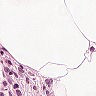

In [14]:
im_negative_example = Image.open('train/f38a6374c348f90b587e046aac6079959adf3835.tif')
im_negative_example.show()

In [15]:
imarray_negative_example = np.array(im_negative_example)
imarray_negative_example.shape

(96, 96, 3)

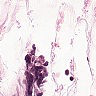

In [16]:
im_positive_example = Image.open('train/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif')
im_positive_example.show()

In [17]:
imarray_positive_example = np.array(im_positive_example)
imarray_positive_example.shape

(96, 96, 3)

Each image is 96x96x3 pixels' shape, and is RGB image

# **Step 2 : Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data**
Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?


**Histogram of class labels**

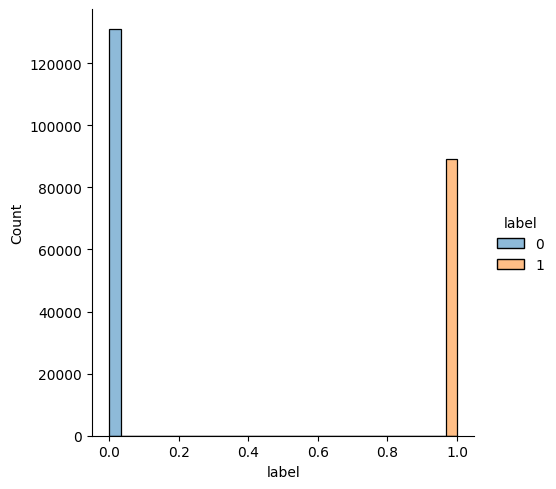

In [18]:
## histogram of class labels
sns.displot(data=df, x='label', hue='label')

In [19]:
# we will choose 80000 images of each label to create the balanced training/validation dataset
# take a random sample of class 0 with size equal to num samples in class 1
SAMPLE_SIZE = 80000
df_0 = df[df['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)
df_1 = df[df['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)
print(df_data['label'].value_counts())
df_data.head()

0    80000
1    80000
Name: label, dtype: int64


,id,label
59256,03a6502cab588ba2d061d91a8f0073fc78990807,0
47458,4fb13fb87f330e9995aacbe7f47cf20477d14013,0
114606,adf5f1a48ef3abf84d175537d46dc61dd56ed891,1
106357,f71a632825329c4dac43f9a9b8125acc82547ade,1
1383,0537c822b01467dc9522c678d81f9086367f6961,0


**Now lets generate more plots looking at each class individually**

In [20]:
# We will pick 10000 images
N = 10000
df_data_samples = df_data.head(N)
X = np.zeros([N,96,96,3],dtype=np.uint8)
for i in range(N):
  X[i] = imread('train/' + df_data_samples.iloc[i]['id'] + '.tif')



In [21]:
y = df_data_samples['label'].values

In [22]:
positive_samples = X[y == 1]
negative_samples = X[y == 0]

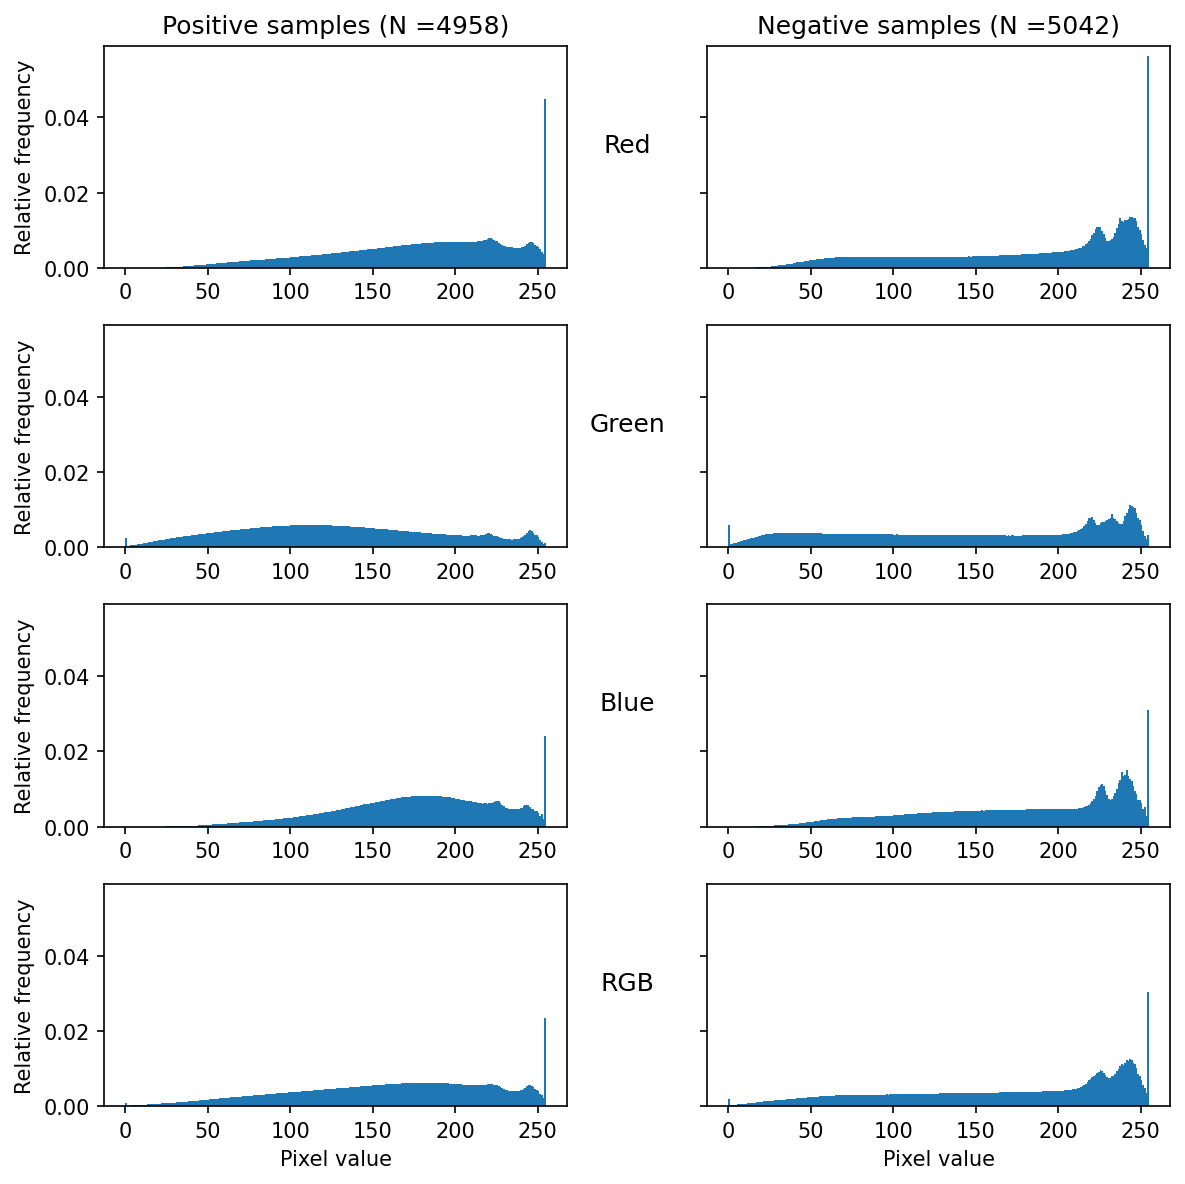

In [23]:
nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

#RGB channels
axs[0,0].hist(positive_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[0,1].hist(negative_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[1,0].hist(positive_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[1,1].hist(negative_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[2,0].hist(positive_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)
axs[2,1].hist(negative_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)

#All channels
axs[3,0].hist(positive_samples.flatten(),bins=nr_of_bins,density=True)
axs[3,1].hist(negative_samples.flatten(),bins=nr_of_bins,density=True)
#Set image labels
axs[0,0].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
axs[0,1].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
for i in range(4):
    axs[i,0].set_ylabel("Relative frequency")
axs[3,0].set_xlabel("Pixel value")
axs[3,1].set_xlabel("Pixel value")
fig.tight_layout()

So we can already spot differences in the distributions of all channels individually and together between positive and negative samples:

Negative samples seem to have higher, i.e. brighter, pixel values in general and especially in the green color channel.
Interestingly, the positive samples have a darker green channel than red and blue while this is not true for the negative samples. However, very dark pixels are for both sample sets mostly only present in the green channel.
Furthermore, note the relatively high frequency of the pixel value 255. Looking at the data above we can see, that these can likely be attributed to the bright white image regions present in some images. They seem to be present in both positive and negative samples similarly frequently.  

Now, let's switch perspective and look at the distribution of mean image brightness, i.e. mean image pixel values. Note, previously we were averaging over all pixel values in the positive and negative samples. Now, we will take the mean of each individual image and look at that distribution.

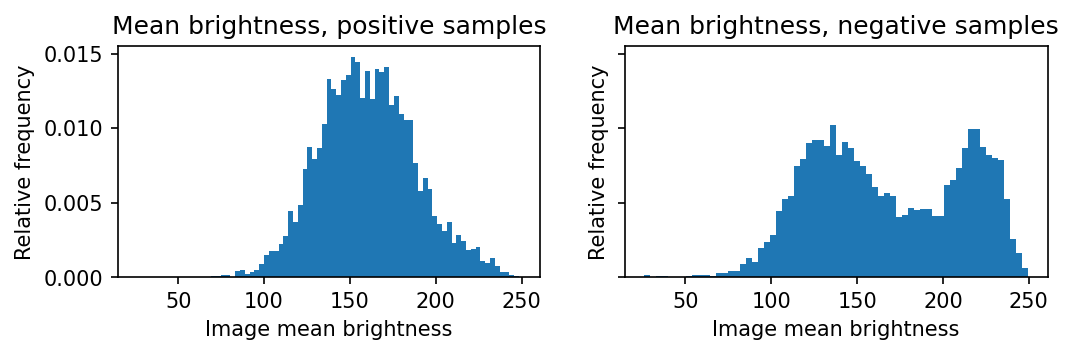

In [24]:
nr_of_bins = 64 #we use a bit fewer bins to get a smoother image
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=150)
axs[0].hist(np.mean(positive_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[1].hist(np.mean(negative_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[0].set_title("Mean brightness, positive samples");
axs[1].set_title("Mean brightness, negative samples");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency");

Once again, we can spot pretty obvious differenes between the positive and negative samples. The distribution of mean brightness for the positive samples looks almost like a normal distribution around a brightness of 150. The negative samples, however, seem to follow some bimodal distribution with peaks around 140 and 225.

Conclusions:

There are some easily spotted differences in the distributions of pixel values and mean image brightness between positive and negative samples. This is good, because whatever model we will use can likely use this.
Some of the images seem to contain very bright regions, which are likely artifacts of the recording process. We might have to find a way to deal with them. They are almost equally distributed between positive and negative samples and, hence, probably not easily usable as a feature.
We have about 50% more negative than positive samples. This might require adjustments.

**Let's load image itself into our data and run train validation split**  
We will also normalize the pixel values in between [0-1]

In [25]:
train_dir, test_dir = f'train/', f'test/'
batch_size = 256
df_data['label'] = df_data['label'].astype(str)
df_data['id'] = df_data['id'] + '.tif'
IMAGE_SIZE = 96

In [26]:
# scale the images to have pixel values in between [0-1]
# create 80-20 train-validation split of the training dataset for model evaluation
generator = ImageDataGenerator(rescale=1./255, validation_split=0.20)

train_data = generator.flow_from_dataframe(
    dataframe = df_data,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    x_col='id', # filenames
    y_col='label', # labels
    directory=train_dir,
    subset='training',
    batch_size=batch_size,
    class_mode='categorical')

val_data = generator.flow_from_dataframe(
    dataframe= df_data,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    x_col='id', # filenames
    y_col='label', # labels
    directory=train_dir,
    subset="validation",
    batch_size=batch_size,
    class_mode='categorical')




Found 128000 validated image filenames belonging to 2 classes.
Found 32000 validated image filenames belonging to 2 classes.


In [27]:
images_test = pd.DataFrame({'id':os.listdir(test_dir)})
generator_test = ImageDataGenerator(rescale=1./255) # scale the test images to have pixel values in [0-1]

test_data = generator_test.flow_from_dataframe(
    dataframe = images_test,
    x_col='id', # filenames
    directory=test_dir,
    class_mode=None,
    batch_size=1,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    shuffle=False)

Found 57458 validated image filenames.


# **Step 3 : Model Architecture**  


## **Basic CNN**

We will now focus on creating a simple and classical model for this problem first.  
Model structure (optimizer: Adam):

*   In
*   [Conv2D*3 -> MaxPool2D -> Dropout] x3 --> (filters = 16, 32, 64)
*   Flatten
*   Dense (256)
*   Dropout
*   Out







In [66]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model_cnn1 = Sequential()
model_cnn1.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model_cnn1.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model_cnn1.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model_cnn1.add(MaxPooling2D(pool_size = pool_size))
model_cnn1.add(Dropout(dropout_conv))

model_cnn1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model_cnn1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model_cnn1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model_cnn1.add(MaxPooling2D(pool_size = pool_size))
model_cnn1.add(Dropout(dropout_conv))

model_cnn1.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model_cnn1.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model_cnn1.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model_cnn1.add(MaxPooling2D(pool_size = pool_size))
model_cnn1.add(Dropout(dropout_conv))

model_cnn1.add(Flatten())
model_cnn1.add(Dense(256, activation = "relu"))
model_cnn1.add(Dropout(dropout_dense))
model_cnn1.add(Dense(2, activation = "softmax"))

model_cnn1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 conv2d_39 (Conv2D)          (None, 92, 92, 32)        9248      
                                                                 
 conv2d_40 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 45, 45, 32)        0         
                                                                 
 conv2d_41 (Conv2D)          (None, 43, 43, 64)        18496     
                                                      

In [29]:
model_cnn1.compile(Adam(lr=0.0001), loss='binary_crossentropy',
              metrics=['accuracy'])

In [60]:
# filepath = "model.h5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
#                              save_best_only=True, mode='max')

# reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
#                                    verbose=1, mode='max', min_lr=0.00001)


# callbacks_list = [checkpoint, reduce_lr]

history = model_cnn1.fit_generator(train_data,
                    validation_data=val_data,
                    epochs=20, verbose=1)
                  #  callbacks=callbacks_list)


Epoch 1/20
500/500 [==============================] - 113s 226ms/step - loss: 0.2960 - accuracy: 0.8749 - val_loss: 0.3199 - val_accuracy: 0.8590
Epoch 2/20
500/500 [==============================] - 114s 228ms/step - loss: 0.2891 - accuracy: 0.8775 - val_loss: 0.3044 - val_accuracy: 0.8747
Epoch 3/20
500/500 [==============================] - 115s 229ms/step - loss: 0.2865 - accuracy: 0.8788 - val_loss: 0.3748 - val_accuracy: 0.8393
Epoch 4/20
500/500 [==============================] - 114s 229ms/step - loss: 0.2753 - accuracy: 0.8851 - val_loss: 0.4250 - val_accuracy: 0.8167
Epoch 5/20
500/500 [==============================] - 114s 229ms/step - loss: 0.2706 - accuracy: 0.8863 - val_loss: 0.2856 - val_accuracy: 0.8811
Epoch 6/20
500/500 [==============================] - 113s 225ms/step - loss: 0.2681 - accuracy: 0.8875 - val_loss: 0.3377 - val_accuracy: 0.8543
Epoch 7/20
500/500 [==============================] - 113s 226ms/step - loss: 0.2614 - accuracy: 0.8916 - val_loss: 0.2949 -

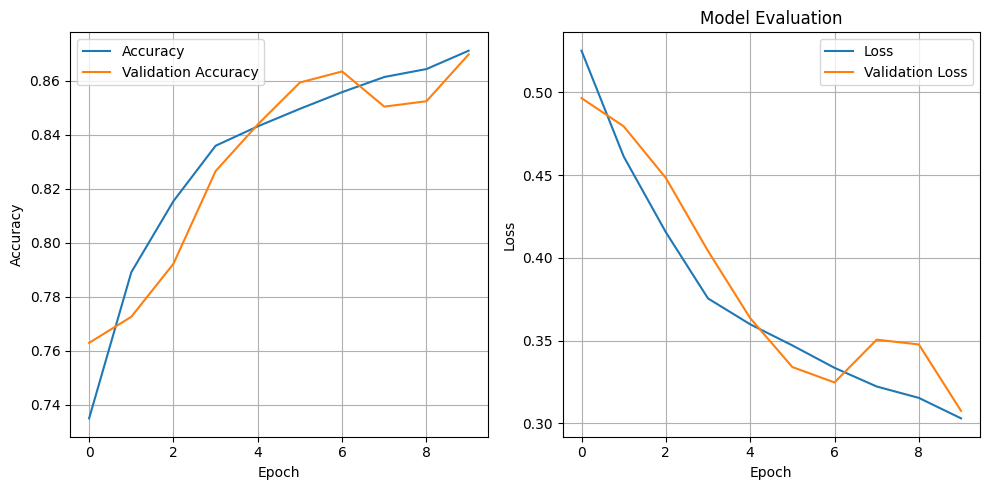

In [59]:
def plot_hist(hist):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history['val_accuracy'])
    plt.legend(["Accuracy","Validation Accuracy"])
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.grid()
    plt.subplot(122)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("Model Evaluation")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.grid()
    plt.legend(["Loss","Validation Loss"])
    plt.tight_layout()
    plt.show()

plot_hist(history)

## **CNN : Faster learning rate**

In [67]:

model_cnn2 = Sequential(
                        [Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)), \
                         Conv2D(first_filters, kernel_size, activation = 'relu'), \
                         Conv2D(first_filters, kernel_size, activation = 'relu'), \
                         MaxPooling2D(pool_size = pool_size), \
                         Dropout(dropout_conv), \
                         Conv2D(second_filters, kernel_size, activation ='relu'), \
                         Conv2D(second_filters, kernel_size, activation ='relu'), \
                         Conv2D(second_filters, kernel_size, activation ='relu'), \
                         MaxPooling2D(pool_size = pool_size), \
                         Dropout(dropout_conv), \
                         Conv2D(third_filters, kernel_size, activation ='relu'), \
                         Conv2D(third_filters, kernel_size, activation ='relu'), \
                         Conv2D(third_filters, kernel_size, activation ='relu'), \
                         MaxPooling2D(pool_size = pool_size), \
                         Dropout(dropout_conv), \
                         Flatten(), \
                         Dense(256, activation = "relu"), \
                         Dropout(dropout_dense), \
                         Dense(2, activation = "softmax")])

model_cnn2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 conv2d_48 (Conv2D)          (None, 92, 92, 32)        9248      
                                                                 
 conv2d_49 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 45, 45, 32)        0         
                                                                 
 conv2d_50 (Conv2D)          (None, 43, 43, 64)        18496     
                                                      

In [68]:
model_cnn2.compile(Adam(lr=0.001), loss='binary_crossentropy',
              metrics=['accuracy'])

In [69]:
history2 = model_cnn2.fit_generator(train_data,
                    validation_data=val_data,
                    epochs=20, verbose=1)

Epoch 1/20
500/500 [==============================] - 115s 228ms/step - loss: 0.4869 - accuracy: 0.7713 - val_loss: 0.4181 - val_accuracy: 0.8112
Epoch 2/20
500/500 [==============================] - 114s 228ms/step - loss: 0.3954 - accuracy: 0.8250 - val_loss: 0.3449 - val_accuracy: 0.8536
Epoch 3/20
500/500 [==============================] - 114s 227ms/step - loss: 0.3517 - accuracy: 0.8480 - val_loss: 0.3446 - val_accuracy: 0.8487
Epoch 4/20
500/500 [==============================] - 114s 228ms/step - loss: 0.3224 - accuracy: 0.8625 - val_loss: 0.3340 - val_accuracy: 0.8643
Epoch 5/20
500/500 [==============================] - 114s 228ms/step - loss: 0.3026 - accuracy: 0.8727 - val_loss: 0.2870 - val_accuracy: 0.8805
Epoch 6/20
500/500 [==============================] - 112s 224ms/step - loss: 0.2828 - accuracy: 0.8822 - val_loss: 0.2560 - val_accuracy: 0.8954
Epoch 7/20
500/500 [==============================] - 114s 228ms/step - loss: 0.2649 - accuracy: 0.8914 - val_loss: 0.2889 -

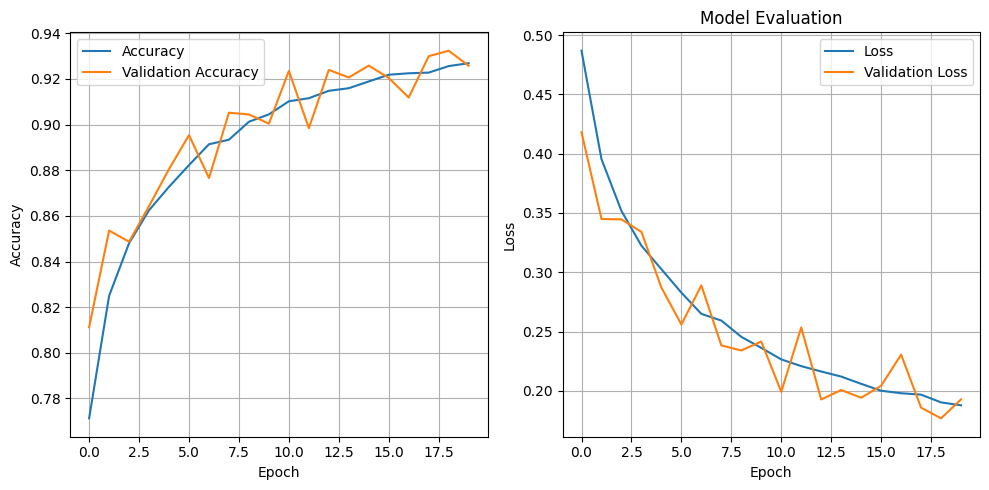

In [70]:
plot_hist(history2)

## **CNN : Tune optimizer (SGD, RMSPROP)**

In [80]:
model_cnn4 = Sequential(
                        [Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)), \
                         Conv2D(first_filters, kernel_size, activation = 'relu'), \
                         Conv2D(first_filters, kernel_size, activation = 'relu'), \
                         MaxPooling2D(pool_size = pool_size), \
                         Dropout(dropout_conv), \
                         Conv2D(second_filters, kernel_size, activation ='relu'), \
                         Conv2D(second_filters, kernel_size, activation ='relu'), \
                         Conv2D(second_filters, kernel_size, activation ='relu'), \
                         MaxPooling2D(pool_size = pool_size), \
                         Dropout(dropout_conv), \
                         Conv2D(third_filters, kernel_size, activation ='relu'), \
                         Conv2D(third_filters, kernel_size, activation ='relu'), \
                         Conv2D(third_filters, kernel_size, activation ='relu'), \
                         MaxPooling2D(pool_size = pool_size), \
                         Dropout(dropout_conv), \
                         Flatten(), \
                         Dense(256, activation = "relu"), \
                         Dropout(dropout_dense), \
                         Dense(2, activation = "softmax")])
model_cnn4.compile(SGD(lr=0.001), loss='binary_crossentropy',
              metrics=['accuracy'])
history4 = model_cnn4.fit_generator(train_data,
                    validation_data=val_data,
                    epochs=20, verbose=1)

Epoch 1/20
500/500 [==============================] - 116s 231ms/step - loss: 0.6934 - accuracy: 0.4988 - val_loss: 0.6932 - val_accuracy: 0.5008
Epoch 2/20
500/500 [==============================] - 114s 228ms/step - loss: 0.6933 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.5109
Epoch 3/20
500/500 [==============================] - 115s 231ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6931 - val_accuracy: 0.5771
Epoch 4/20
500/500 [==============================] - 116s 232ms/step - loss: 0.6931 - accuracy: 0.5031 - val_loss: 0.6931 - val_accuracy: 0.5896
Epoch 5/20
500/500 [==============================] - 113s 227ms/step - loss: 0.6931 - accuracy: 0.5058 - val_loss: 0.6930 - val_accuracy: 0.6217
Epoch 6/20
500/500 [==============================] - 113s 225ms/step - loss: 0.6930 - accuracy: 0.5073 - val_loss: 0.6929 - val_accuracy: 0.5950
Epoch 7/20
500/500 [==============================] - 113s 227ms/step - loss: 0.6929 - accuracy: 0.5143 - val_loss: 0.6929 -

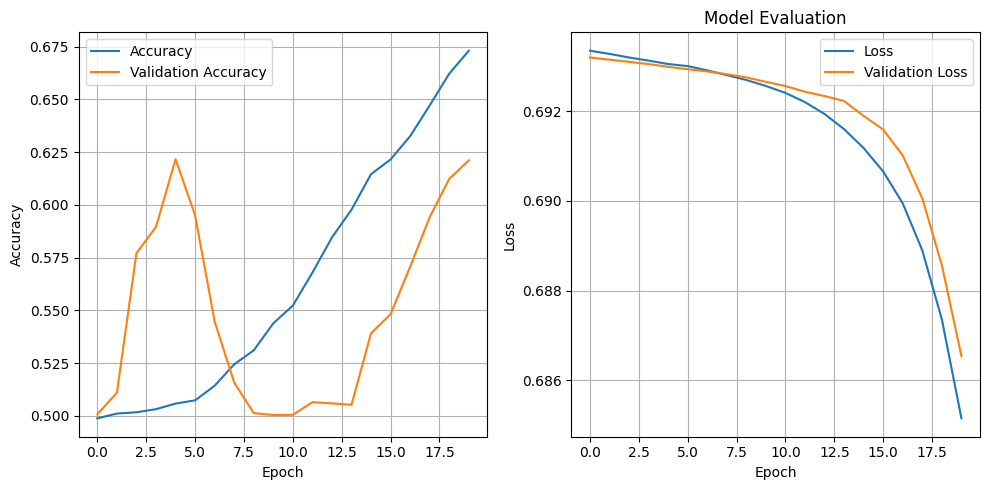

In [86]:
plot_hist(history4)

In [81]:
model_cnn5 = Sequential(
                        [Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)), \
                         Conv2D(first_filters, kernel_size, activation = 'relu'), \
                         Conv2D(first_filters, kernel_size, activation = 'relu'), \
                         MaxPooling2D(pool_size = pool_size), \
                         Dropout(dropout_conv), \
                         Conv2D(second_filters, kernel_size, activation ='relu'), \
                         Conv2D(second_filters, kernel_size, activation ='relu'), \
                         Conv2D(second_filters, kernel_size, activation ='relu'), \
                         MaxPooling2D(pool_size = pool_size), \
                         Dropout(dropout_conv), \
                         Conv2D(third_filters, kernel_size, activation ='relu'), \
                         Conv2D(third_filters, kernel_size, activation ='relu'), \
                         Conv2D(third_filters, kernel_size, activation ='relu'), \
                         MaxPooling2D(pool_size = pool_size), \
                         Dropout(dropout_conv), \
                         Flatten(), \
                         Dense(256, activation = "relu"), \
                         Dropout(dropout_dense), \
                         Dense(2, activation = "softmax")])
model_cnn5.compile(RMSprop(lr=0.001), loss='binary_crossentropy',
              metrics=['accuracy'])
history5 = model_cnn5.fit_generator(train_data,
                    validation_data=val_data,
                    epochs=20, verbose=1)

Epoch 1/20
500/500 [==============================] - 115s 227ms/step - loss: 0.6482 - accuracy: 0.6413 - val_loss: 0.6942 - val_accuracy: 0.6587
Epoch 2/20
500/500 [==============================] - 115s 230ms/step - loss: 0.4853 - accuracy: 0.7752 - val_loss: 0.4477 - val_accuracy: 0.8055
Epoch 3/20
500/500 [==============================] - 112s 223ms/step - loss: 0.4481 - accuracy: 0.7960 - val_loss: 0.3906 - val_accuracy: 0.8189
Epoch 4/20
500/500 [==============================] - 112s 223ms/step - loss: 0.4197 - accuracy: 0.8119 - val_loss: 0.3778 - val_accuracy: 0.8340
Epoch 5/20
500/500 [==============================] - 113s 227ms/step - loss: 0.3990 - accuracy: 0.8232 - val_loss: 0.3372 - val_accuracy: 0.8561
Epoch 6/20
500/500 [==============================] - 112s 224ms/step - loss: 0.3744 - accuracy: 0.8341 - val_loss: 0.3610 - val_accuracy: 0.8478
Epoch 7/20
500/500 [==============================] - 114s 229ms/step - loss: 0.3618 - accuracy: 0.8414 - val_loss: 0.3015 -

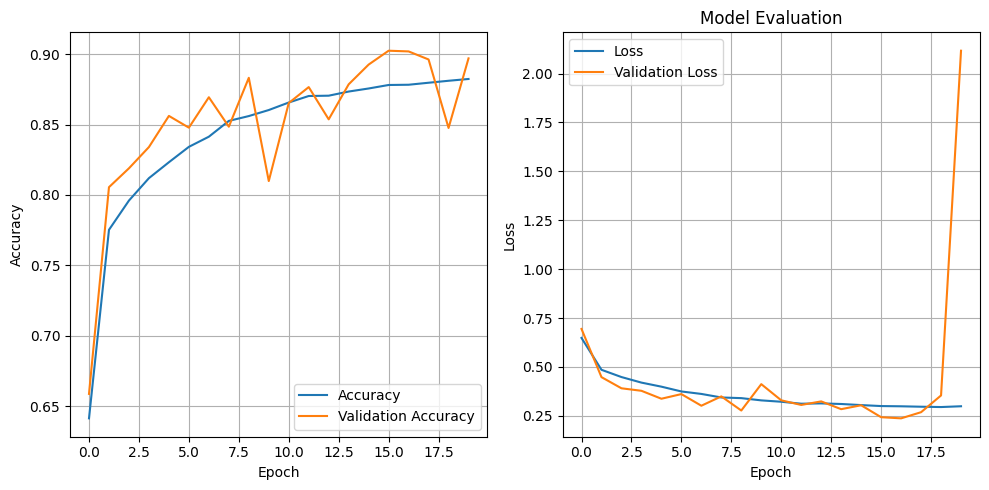

In [82]:
plot_hist(history5)

## **TRANSFER LEARNING**

VGG19 is a variant of the VGG model which in short consists of 19 layers (16 convolution layers, 3 Fully connected layer, 5 MaxPool layers and 1 SoftMax layer). There are other variants of VGG like VGG11, VGG16 and others. VGG19 has 19.6 billion FLOPs.  
Refer https://blog.techcraft.org/vgg-19-convolutional-neural-network/

In [87]:
import tensorflow as tf
base_model = tf.keras.applications.VGG19(
    input_shape=(96,96,3),
    include_top=False,
    weights='imagenet'
)
tf.random.set_seed(1)
model_vgg19 = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(2, activation='softmax')
], name='vgg19_backbone')

model_vgg19.summary()

Model: "vgg19_backbone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten_11 (Flatten)        (None, 4608)              0         
                                                                 
 batch_normalization_22 (Bat  (None, 4608)             18432     
 chNormalization)                                                
                                                                 
 dense_23 (Dense)            (None, 16)                73744     
                                                                 
 dropout_42 (Dropout)        (None, 16)                0         
                                                                 
 dense_24 (Dense)            (None, 8)                 136       
                                                    

In [92]:
opt = Adam(lr=0.0001)
base_model.trainable = True
model_vgg19.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


**Lessons learned:**  
Initially I set learning rate = 0.001 the val_accuracy is always 0.5 for first few epochs, I interrupted the execution and through the research and learned the learning rate is the key problem and then set it lower, which generates very good result even from epoch 1!

In [93]:
history6 = model_vgg19.fit_generator(train_data,
                    validation_data=val_data,
                    epochs=20, verbose=1)

Epoch 1/20
500/500 [==============================] - 117s 229ms/step - loss: 0.2075 - accuracy: 0.9251 - val_loss: 0.2002 - val_accuracy: 0.9252
Epoch 2/20
500/500 [==============================] - 115s 231ms/step - loss: 0.1992 - accuracy: 0.9272 - val_loss: 0.1875 - val_accuracy: 0.9308
Epoch 3/20
500/500 [==============================] - 114s 228ms/step - loss: 0.1946 - accuracy: 0.9302 - val_loss: 0.2449 - val_accuracy: 0.9050
Epoch 4/20
500/500 [==============================] - 115s 229ms/step - loss: 0.1885 - accuracy: 0.9323 - val_loss: 0.1940 - val_accuracy: 0.9284
Epoch 5/20
500/500 [==============================] - 114s 228ms/step - loss: 0.1875 - accuracy: 0.9329 - val_loss: 0.1812 - val_accuracy: 0.9294
Epoch 6/20
500/500 [==============================] - 115s 230ms/step - loss: 0.1818 - accuracy: 0.9349 - val_loss: 0.1643 - val_accuracy: 0.9399
Epoch 7/20
500/500 [==============================] - 115s 229ms/step - loss: 0.1795 - accuracy: 0.9362 - val_loss: 0.2397 -

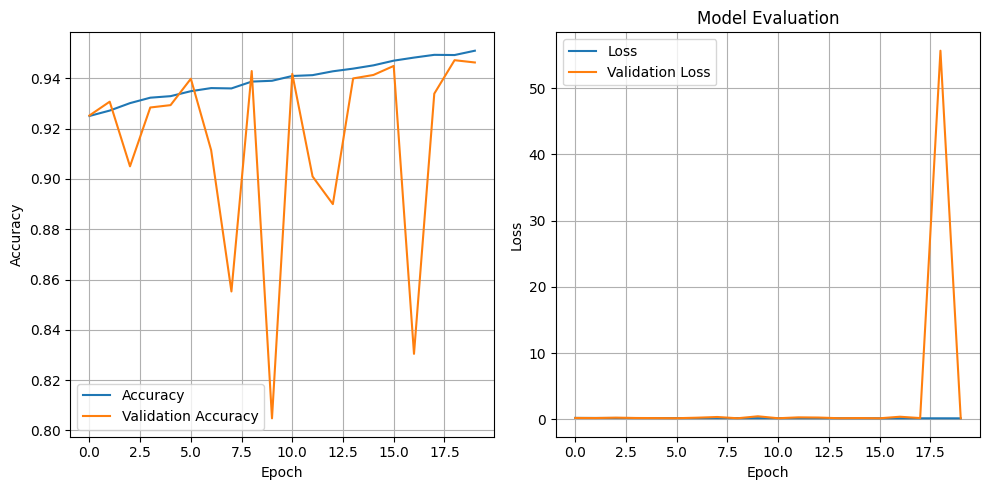

In [94]:
plot_hist(history6)

ResNet stands for Residual Network and is a specific type of convolutional neural network (CNN) introduced in the 2015 paper “Deep Residual Learning for Image Recognition” by He Kaiming, Zhang Xiangyu, Ren Shaoqing, and Sun Jian. CNNs are commonly used to power computer vision applications.

ResNet-50 is a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer). Residual neural networks are a type of artificial neural network (ANN) that forms networks by stacking residual blocks.

Refer : https://datagen.tech/guides/computer-vision/resnet-50/#

In [95]:
base_model = tf.keras.applications.ResNet50(
    input_shape=(96,96,3),
    include_top=False,
    weights='imagenet'
)
np.random.seed(1)
tf.random.set_seed(1)

model_resnet50 = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(2, activation='softmax')
], 'resnet50_backbone')

model_resnet50.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50_backbone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 flatten_12 (Flatten)        (None, 18432)             0         
                                                                 
 batch_normalization_24 (Bat  (None, 18432)            73728     
 chNormalization)                                                
                                                                 
 dense_26 (Dense)            (None, 16)                294928    
                                                                 
 dropout_44 (Dropout)        (None, 16)                0         
                                                                 
 dense_27 (Dense)            (None, 8)            

In [96]:
base_model.trainable = True
opt = Adam(0.0001)
model_resnet50.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


In [97]:
history7 = model_resnet50.fit_generator(train_data,
                    validation_data=val_data,
                    epochs=20, verbose=1)

Epoch 1/20
500/500 [==============================] - 126s 234ms/step - loss: 0.6205 - accuracy: 0.7588 - val_loss: 1.0310 - val_accuracy: 0.5000
Epoch 2/20
500/500 [==============================] - 115s 229ms/step - loss: 0.5277 - accuracy: 0.8361 - val_loss: 0.5287 - val_accuracy: 0.7784
Epoch 3/20
500/500 [==============================] - 115s 230ms/step - loss: 0.4642 - accuracy: 0.8657 - val_loss: 0.3339 - val_accuracy: 0.9445
Epoch 4/20
500/500 [==============================] - 115s 229ms/step - loss: 0.4082 - accuracy: 0.8880 - val_loss: 0.2838 - val_accuracy: 0.9488
Epoch 5/20
500/500 [==============================] - 115s 230ms/step - loss: 0.3597 - accuracy: 0.9056 - val_loss: 0.2570 - val_accuracy: 0.9497
Epoch 6/20
500/500 [==============================] - 115s 230ms/step - loss: 0.3189 - accuracy: 0.9175 - val_loss: 0.2283 - val_accuracy: 0.9521
Epoch 7/20
500/500 [==============================] - 116s 232ms/step - loss: 0.2853 - accuracy: 0.9263 - val_loss: 0.2008 -

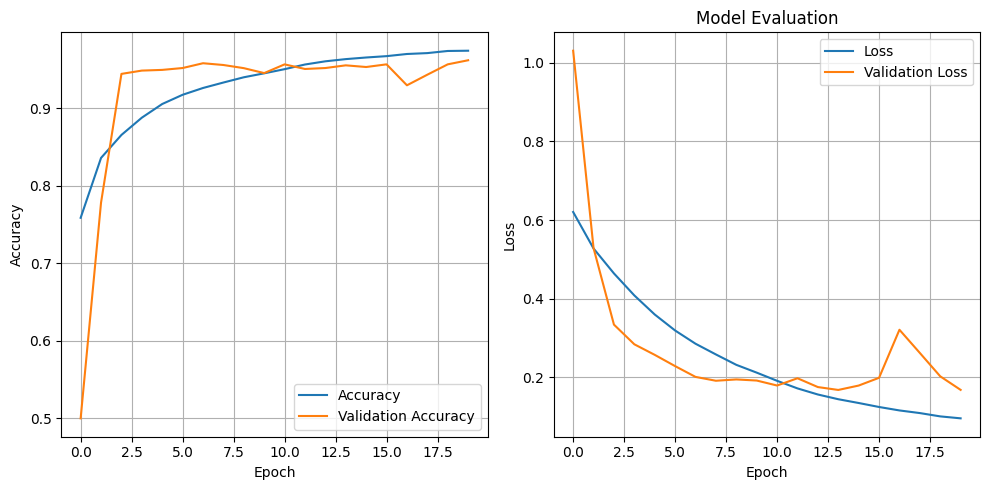

In [98]:
plot_hist(history7)

# **Step 4 : Results and Analysis**



1.   Basic CNN can already generate good result, kaggle submission 0.92 score
2.   Epoch plays a very important role on performance, we can see at least 10 epochs are necessary
3.   Adam optimizer performs much better than SGD, one probable reason is SGD converages very slow and we do not run enough epochs, SGD is usually considered a slow but generalized adapter
4.   RMSProp can quickly ramp up accuracy through epochs while still below the performance of Adam optimizer
5.   TRANSFER learning is an interesting area to explore that nowadays we have so many costly, complex and well-known models shared by large enterprise and academic institute to help with our "small" tasks. We can see performance of model based on VGG19 beats start-from-scratch models and even in epoch 1 it can achieve 0.92+ score, which proves its unique value and convenience.  
Transfer learning model based on ResNet50 takes more epochs to ramp up the accuracy but is also top performer among the models tried in this notebook and is relatively more stable.



# **Step 5 : Conclusion**

Initially, I trained models with free version colab research environment on TPU, but it was very slow, each epoch took more than 2 hours and the runtime often disconnected. There are a few earlier trials I later deleted from this notebook, including:  
1. training with epoch = 10, I see the accuracy curve keeps increasing and not yet reaching flat area yet, meaning epoch = 10 most likely is not enough
2. training with batch normalization, I found out the accuracy curve fluctuate a lot compared with the version without batch normalization, I did some research and found out that batch normalization while helpful with overfitting, but it is very sensitive to network architecture, I would want to have some further research on this area in the future.  

Now back to the models we tried in this notebook. As we could see, the CNN model with adam learning rate 0.001 performs better than learning rate 0.0001 but the training time does not have much difference, likely for smaller learning rate it may require more epoches.
We have also trained popular CNN architectures such as VGG19 and ResNet50 both using pre-trained weights from imagenet, with transfer learning / fine tuning and also training them from scratch, and we obtained much better accuracy, particularly with these models trained from scratch. We could try more recent and complex models such as ResNet101, InceptionV3 or EfficientNet too.

# Final step : generate submission files

**We will use our best model model_resnet50 for submission**

In [99]:
num_test_images = 57458
predictions = model_resnet50.predict_generator(test_data, steps=num_test_images,verbose=1)

57458/57458 [==============================] - 392s 7ms/step


In [100]:
# Put the predictions into a dataframe

df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

df_preds.head()

,no_tumor_tissue,has_tumor_tissue
0,1.000000,1.331071e-08
1,0.998700,1.299607e-03
2,1.000000,1.152312e-09
3,0.980467,1.953255e-02
4,0.002704,9.972962e-01


In [101]:
# This outputs the file names in the sequence in which
# the generator processed the test images.
test_filenames = test_data.filenames

# add the filenames to the dataframe
df_preds['file_names'] = test_filenames

df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names
0,1.000000,1.331071e-08,0996f6519f602db2caec010ac54afeec62c156c6.tif
1,0.998700,1.299607e-03,4440940631c6e16521b2fc4fda7ce7877e8f6e0b.tif
2,1.000000,1.152312e-09,be7c11e55976efe5b92ba555a76b9973738a7bc0.tif
3,0.980467,1.953255e-02,d69c1c40b31192317510c716fcc8fa912b84635c.tif
4,0.002704,9.972962e-01,8fd65e370cb6fdd635f0f8205cdec611d3010e0b.tif


In [102]:
def extract_id(x):

    # split into a list
    b = x.split('.')
    extracted_id = b[0]

    return extracted_id

df_preds['id'] = df_preds['file_names'].apply(extract_id)
df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names,id
0,1.000000,1.331071e-08,0996f6519f602db2caec010ac54afeec62c156c6.tif,0996f6519f602db2caec010ac54afeec62c156c6
1,0.998700,1.299607e-03,4440940631c6e16521b2fc4fda7ce7877e8f6e0b.tif,4440940631c6e16521b2fc4fda7ce7877e8f6e0b
2,1.000000,1.152312e-09,be7c11e55976efe5b92ba555a76b9973738a7bc0.tif,be7c11e55976efe5b92ba555a76b9973738a7bc0
3,0.980467,1.953255e-02,d69c1c40b31192317510c716fcc8fa912b84635c.tif,d69c1c40b31192317510c716fcc8fa912b84635c
4,0.002704,9.972962e-01,8fd65e370cb6fdd635f0f8205cdec611d3010e0b.tif,8fd65e370cb6fdd635f0f8205cdec611d3010e0b


In [103]:
# Get the predicted labels.
# We were asked to predict a probability that the image has tumor tissue
y_pred = df_preds['has_tumor_tissue']

# get the id column
image_id = df_preds['id']

In [104]:
submission = pd.DataFrame({'id':image_id,
                           'label':y_pred,
                          }).set_index('id')

submission.to_csv('patch_preds.csv', columns=['label'])

In [105]:
submission.head()


,label
id,
0996f6519f602db2caec010ac54afeec62c156c6,1.331071e-08
4440940631c6e16521b2fc4fda7ce7877e8f6e0b,1.299607e-03
be7c11e55976efe5b92ba555a76b9973738a7bc0,1.152312e-09
d69c1c40b31192317510c716fcc8fa912b84635c,1.953255e-02
8fd65e370cb6fdd635f0f8205cdec611d3010e0b,9.972962e-01
